# Performance

### Preamble

In [4]:
SYS_PATH = 'C:/Users/mark/Documents/GitHub/honours/dev/package/'
SAVE_PATH = r"C:/Users/mark/Documents/GitHub/honours/submissions/thesis-original"
LOAD_PATH = r"C:/Users/mark/Documents/GitHub/honours/dev/package/analysis/output/temp/output.db"

In [5]:
#standard imports
import sys
import numpy as np
import scipy.stats as stats
import pandas as pd
from datetime import date, timedelta
import math
from itertools import chain

#third party imports
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as tkr
import seaborn as sns
from sklearn import metrics

#local imports
sys.path.append(SYS_PATH)

In [6]:
%matplotlib inline

TINY_SIZE, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE  = 12, 16, 20, 30
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_palette("colorblind")
rcParams['font.family'] = 'serif' 
rcParams['font.serif'] = 'CMU Serif' 
rcParams['font.weight'] = 'bold'
rcParams['font.size'] = SMALL_SIZE #default font size
rcParams['axes.titlesize'] =SMALL_SIZE   # fontsize of the axes title
rcParams['axes.labelsize'] =MEDIUM_SIZE    # fontsize of the x and y labels
rcParams['xtick.labelsize'] =SMALL_SIZE    # fontsize of the tick labels
rcParams['ytick.labelsize'] =SMALL_SIZE   # fontsize of the tick labels
rcParams['legend.fontsize'] =SMALL_SIZE    # legend fontsize
rcParams['figure.titlesize'] =BIGGER_SIZE  # fontsize of the figure title
rcParams['figure.figsize'] = (8,3)
pd.set_option('precision',3)
outline_bars = dict(linewidth = 1.25, edgecolor = '.15')

In [7]:
def get_results(build, stage):
    
    df = pd.read_pickle(r"C:\Users\mark\Documents\GitHub\honours\dev\package\analysis\output\autoVC\{}\{}\log_results.pkl".format(build, stage))
    df = df.reset_index()
    try: df["Time"] = pd.to_numeric(df["mean_fit_time"],errors="coerce")
    except: print("Error: Time")
    try: df["Imputer"] = df["param_imputer__strategy"].map({"most_frequent": "Mode", "median": "Median", "mean": "Mean"})
    except: print("Error: Imputer")
    try: df["Transformer"] = df["param_transformer__func"].astype(str).map({"None":"None","<ufunc 'sqrt'>":"SQRT","<ufunc 'log1p'>": "Log1P"})
    except: print("Error: Transformer")
    try: df["Scaler"] = df['param_scaler'].apply(lambda x: str(x).split("(")[0])
    except: print("Error: Scaler")
    try: 
        df["param_extractor__n_components_bin_20"] = df["param_extractor__n_components"] // 20
        df["Extractor"]=df['param_extractor__n_components_bin_20'].map({0 : "1-20", 1 : "21-40", 2: "41-60",3: "61-80", 4: "81-100"})
    except: print("Error: Extractor")
    try: 
        df["Classifier"] = df["Classifier"].apply(lambda x: str(x).split("(")[0])
        df["Classifier"]=df['Classifier'].map({"LogisticRegression": "Logistic Regression", "RandomForestClassifier":"Random Forest", "DecisionTreeClassifier": "Decision Tree", "GaussianNB": "Naive Bayes", "MLPClassifier": "Artificial Neural Network", "KNeighborsClassifier": "K-Nearest Neighbors", "CalibratedClassifierCV": "Support Vector Machine"})
    except: print("Error: Classifier")
    try:
        df["label_date"] = df["label_slice"]
        df["label_date_str"] = df["label_date"].astype(str)
        df["feature_date"] = df["feature_slice"]
        df["feature_date_str"] = df["feature_date"].astype(str)
        df["forecast_window"] =  df["label_date"] - df["feature_date"]
        df["forecast_window_years"] = df["forecast_window"].apply(lambda x: x.days // 30) / 12
    except: print("Error: Dates")
    try: df["dataset_type"] = df["dataset_type"].map({"train":"Training Score","test":"Test Score"})
    except: print("Error: Learning Curve")
    try: df["label_type"] = df["label_type"].apply(lambda x: x.replace("_", " "))
    except: print("Error: Target Outcome")
    try:
        df["outcome_chance"] = df["label_name"].apply(lambda x: pd.Series(x).value_counts(normalize=True)[1])
    except: print("Error: Outcome")
    df["Params_str"] = df["Params"].astype(str)
    return df

In [37]:
def get_feature_values(df, total="Y_Pred"):
    
    def listify(col):
        if type(col.ix[0]) not in [list, np.ndarray, np.array, pd.Series]: 
            return col.apply(lambda x: [x])
        else: return col
    
    def multip(row):
        for col in row.index:
            if col != "total" and type(row[col]) is list and len(row[col]) != row["total"][0]:
                row[col] = row[col] * row["total"][0]
        return row

    df["total"] = df[total].apply(len)
    df = df.apply(listify, axis=0)
    df = df.apply(multip, axis=1)
    df = df.drop("total",axis=1)
    df = df.apply(lambda x: list(chain.from_iterable(x)),axis=0)
    df = df.apply(pd.Series).T
    return df

In [38]:
def feature_function(df, func, group=None):
    df[["Y_Pred","Y_True"]] = df[["Y_Pred","Y_True"]].apply(lambda x: pd.to_numeric(x,errors="coerce"))
    if group: return df.groupby(group).apply(lambda x: func(x["Y_True"], x["Y_Pred"]))
    else: return func(df["Y_True"], df["Y_Pred"])

In [45]:
def auto_label(ax, fmt='{:,.0f}', adjust=0):
    ymax_old = ax.get_ylim()[1]
    ax.set_ylim(ymax= ax.get_ylim()[1] * 1.1)
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x()+p.get_width()/2.,
            y=np.nanmax([height,0]) + ymax_old * 0.02 + adjust,
            s=fmt.format(np.nanmax([height,0])),
            ha="center")
    ax.yaxis.set_ticks([])

In [137]:
def add_vertical_line(ax, value, label, color, linestyle="dashed"):
    ax.axvline(value, linestyle=linestyle, color=color)
    x_bounds = ax.get_xlim()
    xy_pos = (((value-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01)
    ax.annotate(s=label, xy =xy_pos, xycoords='axes fraction', verticalalignment='right', horizontalalignment='right bottom', color=color)

In [46]:
def add_horizontal_line(ax, value, label, color, linestyle="dashed"):
    ax.axhline(value, linestyle=linestyle, color=color)
    y_bounds = ax.get_ylim()
    xy_pos = (1.01,((value-y_bounds[0])/(y_bounds[1]-y_bounds[0])))
    ax.annotate(s=label, xy =xy_pos, xycoords='axes fraction', verticalalignment='right', horizontalalignment='right bottom', color=color)

In [8]:
def format_axis_ticks(f, axis="x", fmt="{:,}"):
    if type(f.axes[0]) is list: axes = f.axes[0]
    else: axes = [f.axes[0]]
    for ax in axes:
        if axis == "x": ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: fmt.format(int(x))))
        elif axis =="y": ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: fmt.format(int(x))))
        else: raise ValueError

### Performance variation by slice date

In [178]:
reload = True

In [179]:
chart_id = "figures/evaluation/performance_slice"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [180]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = get_results(20, "evaluate")
    data = data[["F1","MCC","PRC","ROC", "feature_date_str", "forecast_window_years"]]
    #data = data.loc[data["forecast_window_years"] == 2]
    total = pd.DataFrame()
    for metric in mtrics:
        temp = data[[metric,"feature_date_str", "forecast_window_years"]]
        temp = temp.rename(index=str, columns={metric: "Score"})
        temp["Metric"] = metric
        total = pd.concat([temp, total], ignore_index=True)
    data = total
    data.to_pickle(pickle_path)

In [181]:
x = "forecast_window_years"
y = "Score"
hue = "Metric"
hue_order = data.groupby(hue)[y].value_counts().index.sort_values(ascending=True).tolist()

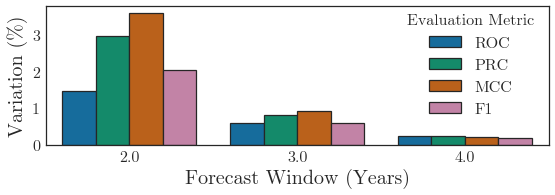

In [184]:
f = plt.figure()
ax = sns.barplot(data=data, x=x, y=y, estimator = lambda x: stats.variation(x) * 100, hue=hue, ci =None, **outline_bars)
ax.set_ylabel("Variation (%)")
ax.set_xlabel("Forecast Window (Years)")
plt.legend(bbox_to_anchor=(1,1.05), title="Evaluation Metric")
plt.tight_layout()

In [185]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Performance by forecast window

In [171]:
reload = True

In [172]:
chart_id = "figures/evaluation/performance_window"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [173]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = get_results(20, "evaluate")
    data = data[["F1","MCC","PRC","ROC", "feature_date_str", "forecast_window_years"]]
    total = pd.DataFrame()
    mtrics = ["F1","MCC","PRC","ROC"]
    for metric in mtrics:
        temp = data[[metric,"feature_date_str", "forecast_window_years"]]
        temp = temp.rename(index=str, columns={metric: "Score"})
        temp["Metric"] = metric
        total = pd.concat([temp, total], ignore_index=True)
    data = total
    data.to_pickle(pickle_path)

In [174]:
x = "Metric" 
y = "Score"
hue = "forecast_window_years"
hue_order = data.groupby(hue)[y].value_counts().index.sort_values(ascending=True).tolist()

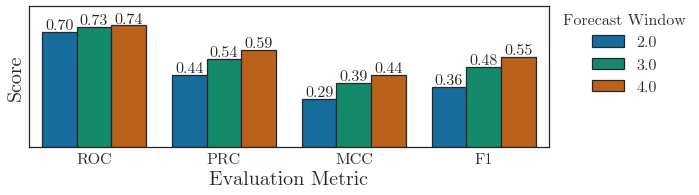

In [175]:
f = plt.figure()
ax = sns.barplot(data=data, x=x, y=y, estimator = np.mean, hue=hue, ci=None, **outline_bars)
auto_label(ax, fmt='{:,.2f}')
ax.set_ylabel("Score")
ax.set_xlabel("Evaluation Metric")
plt.legend(bbox_to_anchor=(1,1.05), title="Forecast Window")
plt.tight_layout()

In [176]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Performance by target outcome

In [164]:
reload = True

In [165]:
chart_id = "figures/evaluation/performance_outcome"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [166]:
def get_data():
    data = get_results(24, "evaluate")
    data["label_type"] = data["label_type"].apply(lambda x: x.replace("_"," "))
    data = data[["Y_Pred", "Y_True", "label_type","forecast_window_years","feature_date_str"]]
    data = get_feature_values(data)
    results = feature_function(data, metrics.f1_score, group = ["forecast_window_years","label_type"])
    if type(results) is pd.Series: results = results.to_frame()
    results = results.reset_index(drop=False)
    results = results.rename(index=str, columns={0:"score","index":"label_type"})
    data = results
    return data

In [167]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = get_data()
    data.to_pickle(pickle_path)

Error: Time
Error: Imputer
Error: Transformer
Error: Scaler
Error: Extractor
Error: Learning Curve


In [168]:
x = "label_type"
y = "score"
hue= "forecast_window_years"
order = ["Extra Stage", "Extra Round", "Exit", "Acquisition", "IPO"]

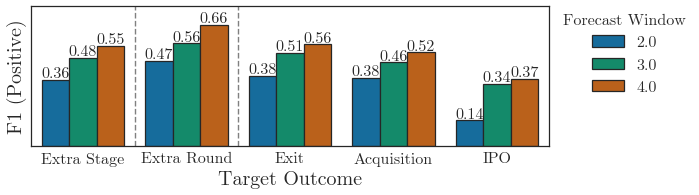

In [169]:
f = plt.figure()
ax = sns.barplot(data=data, x=x, y=y, hue=hue, order=order, **outline_bars)
auto_label(ax, fmt='{:,.2f}')
ax.set_xlabel("Target Outcome")
ax.set_ylabel("F1 (Positive)")
add_vertical_line(ax, 0.5, "", color="grey")
add_vertical_line(ax, 1.5, "", color="grey")
plt.legend(bbox_to_anchor=(1,1.05), title="Forecast Window")
plt.tight_layout()

In [170]:
output_path = "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Performance by developmental stage

In [143]:
reload = True

In [144]:
chart_id = "figures/evaluation/performance_stage"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [145]:
def get_data():
    data = get_results(19, "evaluate")
    data = data[["Y_Pred", "Y_True", "feature_stage","forecast_window_years","feature_date_str"]]
    data = get_feature_values(data)
    results = feature_function(data, metrics.f1_score, group = ["feature_stage"])
    overall = feature_function(data, metrics.f1_score)
    results["Overall"] = overall
    data2 = get_results(21, "evaluate")
    data2["feature_stage_single"] = data2["feature_stage"].apply(lambda x: x.value_counts().index[0])
    data2 = data2[["Y_Pred", "Y_True", "feature_stage_single","forecast_window_years","feature_date_str"]]
    data2 = get_feature_values(data2)
    results2 = feature_function(data2, metrics.f1_score, group = ["feature_stage_single"])
    overall2 = feature_function(data2, metrics.f1_score)
    results2["Overall"] = overall2
    if type(results) is pd.Series: results = results.to_frame()
    results["method"] = "Combined"
    if type(results2) is pd.Series: results2 = results2.to_frame()
    results2["method"] = "Individual"
    results3 = pd.concat([results, results2], axis=0)
    results3 = results3.reset_index(drop=False)
    results3 = results3.rename(index=str, columns={0:"score","index":"stage"})
    data = results3
    return data

In [146]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = get_data()
    data.to_pickle(pickle_path)

In [147]:
x = "stage"
y = "score"
hue = "method"

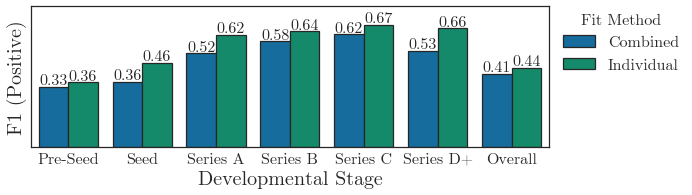

In [148]:
f = plt.figure()
ax = sns.barplot(data=data, x=x, y=y, hue=hue, **outline_bars)
auto_label(ax, fmt='{:,.2f}')
ax.set_xlabel("Developmental Stage")
ax.set_ylabel("F1 (Positive)")
plt.legend(bbox_to_anchor=(1,1.05), title="Fit Method")
plt.tight_layout()

In [149]:
output_path = "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Example company profiles and their predictions